In [1]:
import os
import datetime

import numpy as np
import scipy
import fiona
import statistics
import math

import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, shape, mapping, Point, Polygon, MultiPolygon
from shapely.ops import cascaded_union

import matplotlib.pyplot as plt
from matplotlib import colors, cm, style
import matplotlib.patches as mpatches
from descartes import PolygonPatch

import osmnx as ox
import networkx as nx

In [2]:
from my_osm import get_osm_data
from my_isochrones import get_isochrones
from my_metrics import compute_edge_betweenness

In [3]:
style.use('seaborn-white')
output_folder = 'data'
osm_crs = 'EPSG:3857'

# Parameters

In [4]:
# Place                                Country              CRS
# Amsterdam | Rotterdam | The Hague    (The Netherlands)    EPSG:28992
# Madrid    | Barcelona | Valencia     (Spain)              EPSG:25830
# Stockholm | Goteborg  | Malmo        (Sweden)             EPSG:3006 ???

place_name = 'Utrecht'
case_name = 'Zuid West'
local_crs = 'EPSG:28992'

In [5]:
buffer = 500

# Load data

In [6]:
place = gpd.read_file(os.path.join(output_folder, 'WijkBuurtkaart_2022_v0', 'SHP', 'CBS_buurten2022.shp'))

In [7]:
if case_name == 'West':
    WK_NAAM = 'Wijk 01 West'
    BU_NAAM_exclude = 'Bedrijventerrein Lageweide'
    place = place[(place['GM_NAAM']==place_name) & (place['WK_NAAM']==WK_NAAM) & (place['BU_NAAM']!=BU_NAAM_exclude)]

In [8]:
if case_name == 'Zuid West':
    WK_NAAM = 'Wijk 08 Zuidwest'
    place = place[(place['GM_NAAM']==place_name) & (place['WK_NAAM']==WK_NAAM)]

In [9]:
if case_name == 'Zuid':
    WK_NAAM = 'Wijk 07 Zuid'
    place = place[(place['GM_NAAM']==place_name) & (place['WK_NAAM']==WK_NAAM)]

In [10]:
place = gpd.GeoDataFrame(index=[0], crs=local_crs, geometry=[place.unary_union])

In [11]:
extent = place.buffer(buffer, join_style=2)
if len(extent) > 1:
    extent_shape = MultiPolygon([shape(part) for part in extent.to_crs('EPSG:4326')])     
else:
    extent_shape = extent.to_crs('EPSG:4326')[0]

### Pedestrian network

In [12]:
# custom filter: using the osmnx network_type 'walk' as a basis,
# but NOT excluding 'cycleways'.
# see https://github.com/gboeing/osmnx/blob/main/osmnx/downloader.py
# and https://github.com/gboeing/osmnx/issues/169
network_filter = (
        f'["highway"]["area"!~"yes"]["access"!~"private"]'
        f'["highway"!~"abandoned|bus_guideway|construction|motor|planned|platform|proposed|raceway"]'
        f'["foot"!~"no"]["service"!~"private"]'
    )

In [13]:
G_ped = ox.graph_from_polygon(extent_shape, network_type='walk', custom_filter=network_filter, retain_all=True)
G_ped = ox.project_graph(G_ped, to_crs=local_crs)

In [14]:
ped_paths = ox.utils_graph.graph_to_gdfs(ox.get_undirected(G_ped), nodes=False, edges=True).to_crs(local_crs)

In [15]:
G_motor = ox.graph_from_polygon(extent_shape, network_type='drive_service', retain_all=True)
G_motor = ox.project_graph(G_motor, to_crs=local_crs)

In [16]:
motor_paths = ox.utils_graph.graph_to_gdfs(ox.get_undirected(G_motor), nodes=False, edges=True).to_crs(local_crs)

### Barriers

#### roads, speed-based

In [17]:
# 50km/h
highway_speed_filter_50 = (f'["highway"]["maxspeed"~"50"]["tunnel"!="yes"]')
highway_speed_barrier_50 = gpd.clip(get_osm_data(highway_speed_filter_50, extent, 'convexhull'), extent)

In [18]:
# 60km/h and faster
highway_speed_filter_60more = (f'["highway"]["maxspeed"~"60|70|80|90|100|110|120|130"]["tunnel"!="yes"]')
highway_speed_barrier_60more = gpd.clip(get_osm_data(highway_speed_filter_60more, extent, 'convexhull'), extent)

#### roads, type-based

In [19]:
# major national roads
highway_type_filter_major = (f'["highway"~"motorway|motorway_link|trunk|trunk_link|escape|raceway"]["tunnel"!="yes"]')
highway_type_barrier_major = gpd.clip(get_osm_data(highway_type_filter_major, extent, 'convexhull'), extent)

In [20]:
# primary and secondary roads
highway_type_filter_12 = (f'["highway"~"primary|primary_link|secondary|secondary_link"]["tunnel"!="yes"]')
highway_type_barrier_12 = gpd.clip(get_osm_data(highway_type_filter_12, extent, 'convexhull'), extent)

Response <Response [429]>
Waiting 30sec, and trying again max 4 more times
Response <Response [504]>
Waiting 60sec, and trying again max 3 more times


In [21]:
# tertiary roads
highway_type_filter_3 = (f'["highway"~"tertiary|tertiary_link"]["tunnel"!="yes"]')
highway_type_barrier_3 = gpd.clip(get_osm_data(highway_type_filter_3, extent, 'convexhull'), extent)

Response <Response [504]>
Waiting 30sec, and trying again max 4 more times


In [22]:
# busways
highway_type_filter_bus = (f'["highway"~"busway|bus_guideway"]["tunnel"!="yes"]')
highway_type_barrier_bus = get_osm_data(highway_type_filter_bus, extent, 'convexhull')
if len(highway_type_barrier_bus):
    gpd.clip(highway_type_barrier_bus, extent)

Response <Response [504]>
Waiting 30sec, and trying again max 4 more times


#### rail, type-based

In [23]:
# tram
railway_filter_tram = (f'["railway"~"tram|light_rail"]["tunnel"!="yes"]')
railway_barrier_tram = gpd.clip(get_osm_data(railway_filter_tram, extent, 'convexhull'), extent)

In [24]:
# other rail
railway_filter_other = (f'["railway"]["railway"!~"^(razed|abandoned|disused|miniature|tram|light_rail)"]["tunnel"!="yes"]')
railway_barrier_other = gpd.clip(get_osm_data(railway_filter_other, extent, 'convexhull'), extent)

multiline member not handled {'type': 'way', 'ref': 487840867, 'role': '', 'geometry': [{'lat': 52.0900831, 'lon': 5.1089807}, {'lat': 52.0899273, 'lon': 5.1091264}, {'lat': 52.0898938, 'lon': 5.109033}, {'lat': 52.0900531, 'lon': 5.108897}, {'lat': 52.09026, 'lon': 5.1087262}, {'lat': 52.0905554, 'lon': 5.1085117}, {'lat': 52.0907736, 'lon': 5.1083677}, {'lat': 52.090775, 'lon': 5.1083739}, {'lat': 52.0908695, 'lon': 5.1083111}, {'lat': 52.0909563, 'lon': 5.108254}, {'lat': 52.0910399, 'lon': 5.1081983}, {'lat': 52.0910484, 'lon': 5.1082275}, {'lat': 52.0908558, 'lon': 5.108371}, {'lat': 52.090848, 'lon': 5.1083409}, {'lat': 52.090778, 'lon': 5.1083885}, {'lat': 52.0907819, 'lon': 5.1084036}, {'lat': 52.0907857, 'lon': 5.1084186}, {'lat': 52.0905702, 'lon': 5.108583}, {'lat': 52.0902852, 'lon': 5.1088029}, {'lat': 52.0902065, 'lon': 5.108871}, {'lat': 52.0901373, 'lon': 5.1089301}, {'lat': 52.0900831, 'lon': 5.1089807}]}
multiline member not handled {'type': 'way', 'ref': 450282166, '

#### natural, type-based

In [25]:
# blue
natural_filter_blue = (f'["natural"~"water"]')
natural_barrier_blue = gpd.clip(get_osm_data(natural_filter_blue, extent, 'convexhull'), extent)

Response <Response [504]>
Waiting 30sec, and trying again max 4 more times


In [26]:
# parks
natural_filter_parks = '["leisure"~"^(park)"]'
natural_barrier_parks = gpd.clip(get_osm_data(natural_filter_parks, extent, 'convexhull'), extent)

In [27]:
# green, not parks
natural_filter_green1 = '["leisure"~"^(nature_reserve)"]'
natural_barrier_green = get_osm_data(natural_filter_green1, extent, 'convexhull')

In [28]:
natural_filter_green2 = '["landuse"~"^(forest|meadow|grass|village_green|allotments|flowerbed|farmland|farmyard|orchards|vineyard|plant_nursary)"]'
natural_barrier_green = natural_barrier_green.append(get_osm_data(natural_filter_green2, extent, 'convexhull'))

Response <Response [429]>
Waiting 30sec, and trying again max 4 more times


In [29]:
natural_filter_green3 = '["natural"~"^(wood|scrub|heath|grassland|fell|shrubbery)"]'
natural_barrier_green = natural_barrier_green.append(get_osm_data(natural_filter_green3, extent, 'convexhull'))

In [30]:
natural_barrier_green = gpd.clip(natural_barrier_green, extent)

#### betweenness

In [31]:
betw = compute_edge_betweenness(G_motor).to_crs(local_crs)

Convert to igraph ...
Calculating betweenness ...
Convert to dataframe betweenness ...


In [32]:
betw_quantiles = betw['edge_betweenness'].quantile([0.0, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 1.0])
betw_barriers = betw[betw['edge_betweenness']>betw_quantiles[0.9]]

#### filter

In [33]:
def filter_lines_polys(gdf):
    
    if len(gdf):
        filtered = gdf[(gdf.geom_type == 'Polygon')|(gdf.geom_type == 'MultiPolygon')|(gdf.geom_type == 'LineString')|(gdf.geom_type == 'MultiLineString')]
        return filtered
    else:
        return gdf

In [34]:
highway_speed_barrier_50 = filter_lines_polys(highway_speed_barrier_50)
highway_speed_barrier_60more = filter_lines_polys(highway_speed_barrier_60more)

highway_type_barrier_major = filter_lines_polys(highway_type_barrier_major)
highway_type_barrier_12 = filter_lines_polys(highway_type_barrier_12)
highway_type_barrier_3 = filter_lines_polys(highway_type_barrier_3)
highway_type_barrier_bus = filter_lines_polys(highway_type_barrier_bus)

railway_barrier_tram = filter_lines_polys(railway_barrier_tram)
railway_barrier_other = filter_lines_polys(railway_barrier_other)

natural_barrier_blue = filter_lines_polys(natural_barrier_blue)
natural_barrier_parks = filter_lines_polys(natural_barrier_parks)
natural_barrier_green = filter_lines_polys(natural_barrier_green)

#### plots

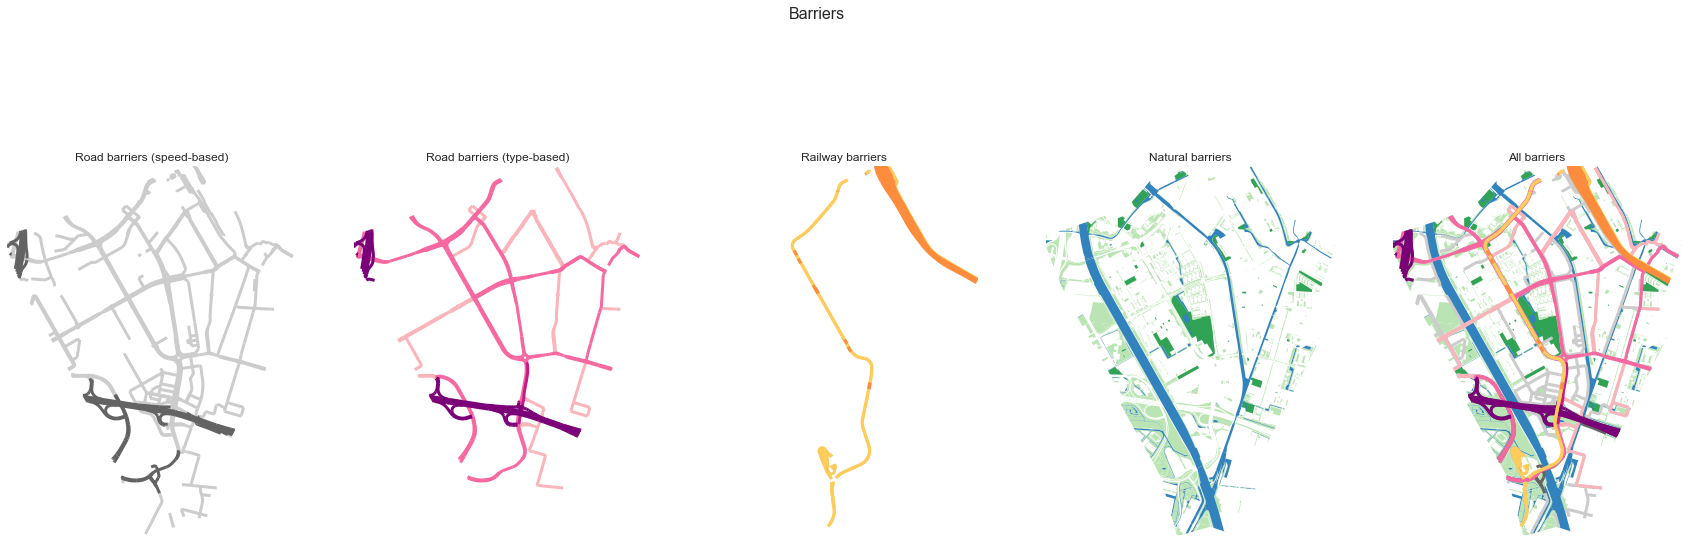

In [35]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30,10))
fig.suptitle('Barriers', fontsize=16)


barrier_width = 3
    
# greys
highway_speed_barrier_50.plot(ax=axs[0], color='#cccccc', linewidth=barrier_width, zorder=1)
highway_speed_barrier_60more.plot(ax=axs[0], color='#636363', linewidth=barrier_width, zorder=2)
axs[0].set_title('Road barriers (speed-based)')

# pink-purple
highway_type_barrier_major.plot(ax=axs[1], color='#7a0177', linewidth=barrier_width, zorder=4)
highway_type_barrier_bus.plot(ax=axs[1], color='#c51b8a', linewidth=barrier_width, zorder=3)
highway_type_barrier_12.plot(ax=axs[1], color='#f768a1', linewidth=barrier_width, zorder=2)
highway_type_barrier_3.plot(ax=axs[1], color='#fbb4b9', linewidth=barrier_width, zorder=1)
axs[1].set_title('Road barriers (type-based)')

# orange
railway_barrier_tram.plot(ax=axs[2], color='#fecc5c', linewidth=barrier_width, zorder=1)
railway_barrier_other.plot(ax=axs[2], color='#fd8d3c', linewidth=barrier_width, zorder=2)
axs[2].set_title('Railway barriers')

# greenblue
natural_barrier_blue.plot(ax=axs[3], color='#3182bd', linewidth=barrier_width, zorder=3)
natural_barrier_parks.plot(ax=axs[3], color='#31a354', linewidth=barrier_width, zorder=2)
natural_barrier_green.plot(ax=axs[3], color='#bae4b3', linewidth=barrier_width, zorder=1)
axs[3].set_title('Natural barriers')

# all combined
highway_speed_barrier_50.plot(ax=axs[4], color='#cccccc', linewidth=barrier_width, zorder=4)
highway_speed_barrier_60more.plot(ax=axs[4], color='#636363', linewidth=barrier_width, zorder=5)
highway_type_barrier_major.plot(ax=axs[4], color='#7a0177', linewidth=barrier_width, zorder=9)
highway_type_barrier_bus.plot(ax=axs[4], color='#c51b8a', linewidth=barrier_width, zorder=8)
highway_type_barrier_12.plot(ax=axs[4], color='#f768a1', linewidth=barrier_width, zorder=7)
highway_type_barrier_3.plot(ax=axs[4], color='#fbb4b9', linewidth=barrier_width, zorder=6)
railway_barrier_tram.plot(ax=axs[4], color='#fecc5c', linewidth=barrier_width, zorder=10)
railway_barrier_other.plot(ax=axs[4], color='#fd8d3c', linewidth=barrier_width, zorder=11)
natural_barrier_blue.plot(ax=axs[4], color='#3182bd', linewidth=barrier_width, zorder=3)
natural_barrier_parks.plot(ax=axs[4], color='#31a354', linewidth=barrier_width, zorder=2)
natural_barrier_green.plot(ax=axs[4], color='#bae4b3', linewidth=barrier_width, zorder=1)
axs[4].set_title('All barriers')


for ax in axs:
    # place.plot(ax=ax, facecolor='none', edgecolor='yellow', linestyle='-', linewidth=1, zorder=1)
    
    bbox = place.total_bounds
    margin = 600
    xlim = ([bbox[0]-margin, bbox[2]+margin])
    ylim = ([bbox[1]-margin, bbox[3]+margin])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.axis('off')

    
plt.show()

#  Store output data

In [36]:
place_name_out = (place_name + '_' + case_name).split(',')[0].replace(' ', '')
today = datetime.date.today().strftime("%d%b%Y")
output_sub_folder = os.path.join(output_folder, '{}_{}'.format(place_name_out, today))

In [37]:
output_sub_folder

'data/Utrecht_ZuidWest_03Oct2022'

In [38]:
if not os.path.exists(output_sub_folder):
    os.mkdir(output_sub_folder)

In [39]:
output_file = os.path.join(output_sub_folder, 'highway_speed_barrier_50.geojson')
highway_speed_barrier_50_out = highway_speed_barrier_50.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
highway_speed_barrier_50_out.to_file(output_file, driver='GeoJSON')

output_file = os.path.join(output_sub_folder, 'highway_speed_barrier_60more.geojson')
highway_speed_barrier_60more_out = highway_speed_barrier_60more.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
highway_speed_barrier_60more_out.to_file(output_file, driver='GeoJSON')

In [40]:
output_file = os.path.join(output_sub_folder, 'highway_type_barrier_major.geojson')
highway_type_barrier_major_out = highway_type_barrier_major.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
highway_type_barrier_major_out.to_file(output_file, driver='GeoJSON')

output_file = os.path.join(output_sub_folder, 'highway_type_barrier_bus.geojson')
highway_type_barrier_bus_out = highway_type_barrier_bus.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
highway_type_barrier_bus_out.to_file(output_file, driver='GeoJSON')

output_file = os.path.join(output_sub_folder, 'highway_type_barrier_12.geojson')
highway_type_barrier_12_out = highway_type_barrier_12.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
highway_type_barrier_12_out.to_file(output_file, driver='GeoJSON')

output_file = os.path.join(output_sub_folder, 'highway_type_barrier_3.geojson')
highway_type_barrier_3_out = highway_type_barrier_3.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
highway_type_barrier_3_out.to_file(output_file, driver='GeoJSON')

In [41]:
output_file = os.path.join(output_sub_folder, 'railway_barrier_tram.geojson')
railway_barrier_tram_out = railway_barrier_tram.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
railway_barrier_tram_out.to_file(output_file, driver='GeoJSON')

output_file = os.path.join(output_sub_folder, 'railway_barrier_other.geojson')
railway_barrier_other_out = railway_barrier_other.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
railway_barrier_other_out.to_file(output_file, driver='GeoJSON')

In [42]:
output_file = os.path.join(output_sub_folder, 'natural_barrier_blue.geojson')
natural_barrier_blue_out = natural_barrier_blue.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
natural_barrier_blue_out.to_file(output_file, driver='GeoJSON')

output_file = os.path.join(output_sub_folder, 'natural_barrier_parks.geojson')
natural_barrier_parks_out = natural_barrier_parks.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
natural_barrier_parks_out.to_file(output_file, driver='GeoJSON')

output_file = os.path.join(output_sub_folder, 'natural_barrier_green.geojson')
natural_barrier_green_out = natural_barrier_green.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
natural_barrier_green_out.to_file(output_file, driver='GeoJSON')